In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split as tts
from tensorflow import keras

In [52]:
train = pd.read_csv('/Users/richardcharles/DSCI478/DigitRecognizer/Data/train.csv')
test = pd.read_csv('/Users/richardcharles/DSCI478/DigitRecognizer/Data/test.csv')

In [53]:
train.head()
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X, y = train.drop('label', axis = 1).values, train['label'].values
test = test.values.reshape(test.shape[0],28,28,1)
X = X.reshape(-1, 28, 28)/255

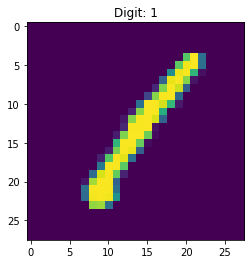

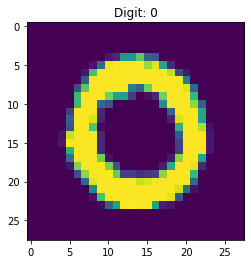

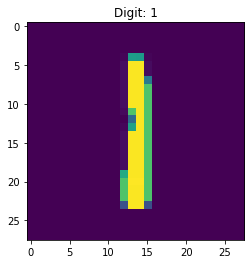

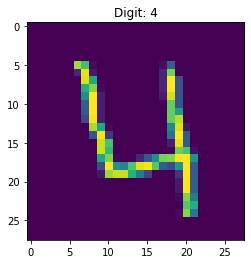

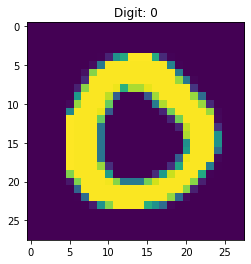

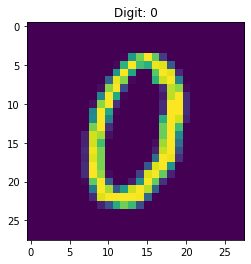

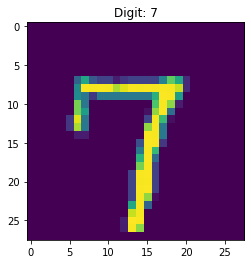

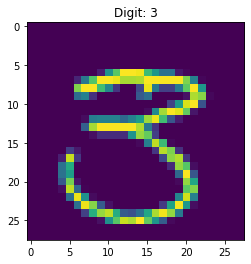

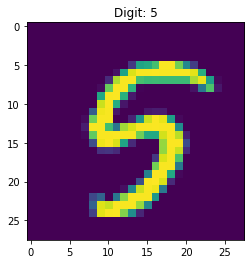

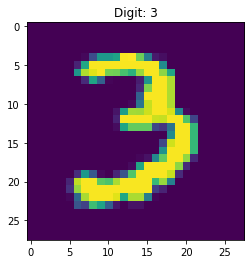

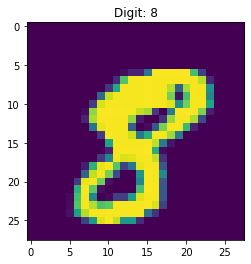

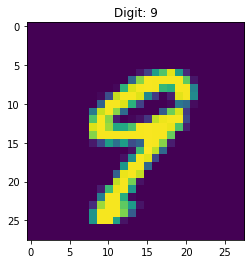

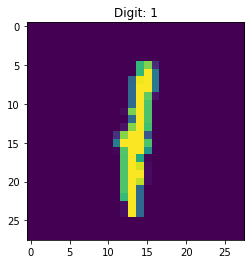

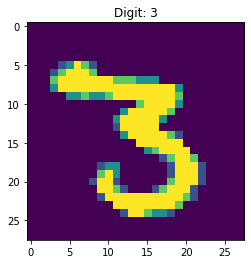

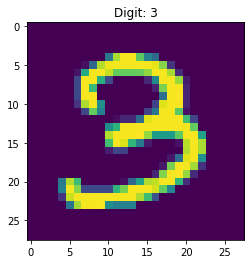

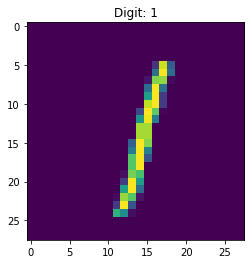

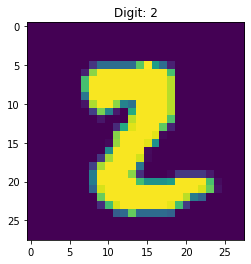

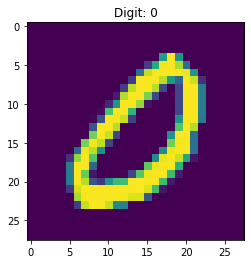

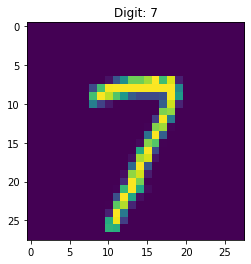

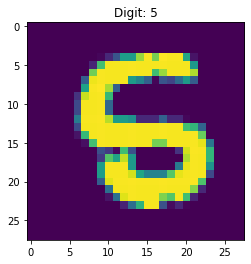

In [55]:
for i in range(0,20):
    plt.imshow(X[i]) 
    plt.title(f"Digit: {y[i]}")
    plt.show() 

In [56]:
x_train, x_valid, y_train, y_valid = tts(X, y, test_size = .1, random_state = 0, stratify = y)

In [57]:
from keras import layers
from keras import models

model = tf.keras.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(10, activation='softmax')])

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

In [59]:
model.compile(optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [60]:
model.fit(x_train, y_train, epochs = 25, batch_size = 124, callbacks = tf.keras.callbacks.EarlyStopping( 
                    patience = 2, 
                    min_delta = 0.001, 
                    restore_best_weights = True, ), verbose = 1)

Epoch 1/25


2022-02-28 18:45:08.357340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


305/305 [==============================] - 5s 13ms/step - loss: 0.3929 - accuracy: 0.8773
Epoch 2/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0946 - accuracy: 0.9715
Epoch 3/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0613 - accuracy: 0.9814
Epoch 4/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0461 - accuracy: 0.9858
Epoch 5/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0380 - accuracy: 0.9889
Epoch 6/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0311 - accuracy: 0.9905
Epoch 7/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0261 - accuracy: 0.9918
Epoch 8/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0228 - accuracy: 0.9930
Epoch 9/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0204 - accuracy: 0.9937
Epoch 10/25
305/305 [==============================] - 4s 13ms/step - loss: 0.0170 - accuracy: 0.9948


In [61]:
loss, acc = model.evaluate(x_valid, y_valid)
acc

 23/132 [====>.........................] - ETA: 0s - loss: 0.0400 - accuracy: 0.9959   

2022-02-28 18:46:48.444842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 1s 5ms/step - loss: 0.0723 - accuracy: 0.9905


0.9904761910438538

In [62]:
pred = model.predict(test, verbose = 0)

2022-02-28 18:46:49.277262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [63]:
pred = np.argmax(pred, axis = 1)
pred

array([2, 0, 9, ..., 3, 9, 2])